# Tutorial 3: Problems and Solvers

**Overview:** This tutorials covers the basics of setting up and solving problems using Dedalus.
Dedalus solves symbolically specified initial value, boundary value, and eigenvalue problems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de

In [2]:
%matplotlib notebook

## 3.1: Problems

### Problem formulations

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations boundary conditions and manipulating them into the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.
This form encapsulates prognostic/evolution equations (equations containing time derivatives) and diagnostic/algebraic constraints (equations without time derivatives), both in the interior of the domain and on the boundary.

Importantly, the left-hand side (LHS) of the equations must be time-independent, first-order in temporal derivatives, and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.
In addition, the LHS must be first-order in non-separable (e.g. Chebyshev) derivatives, and may only contain non-constant coefficients that vary in the non-periodic dimensions (others must be placed on the RHS).

In addition to initial value problems, there are similar standard forms for generalized eigenvalue problems ($\sigma \mathcal{M} \cdot \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = 0$), linear boundary value problems ($\mathcal{L} \cdot \mathcal{X} = \mathcal{G}$), and nonlinear boundary value problems ($\mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X})$).
These four problem types are represented by the `IVP`, `EVP`, `LBVP`, and `NLBVP` problem classes, respectively.

To create a problem object, you must provide a domain object and the names of the variables that appear in the equations.
Let's start setting up the complex Ginzburg-Landau equation (CGLE) for a variable $u(x,t)$ on a finite interval $x \in [0, 300]$ with homogeneous Dirichlet boundary conditions:

$$\partial_t u = u + (1 + i b) \partial_{xx} u - (1 + i c) |u|^2 u$$

$$u(x=0) = u(x=300) = 0$$

The CGLE only has one primative variable but is second-order in its spatial derivatives, so we'll have to introduce an extra variable to reduce the equation to first-order.
We also pick a dealiasing factor of 2 to correctly dealias the cubic nonlinearity.

In [3]:
# Build bases and domain
x_basis = de.Chebyshev('x', 1024, interval=(0, 300), dealias=2)
domain = de.Domain([x_basis], grid_dtype=np.complex128)

# Build problem
problem = de.IVP(domain, variables=['u', 'ux'])

### Variable metadata

Metadata for the problem variables can be specified through the `meta` attribute of the problem object, and indexing by variable name, axis, and property, respectively.  

The most common metadata to set here is the `parity` option when using the `SinCos` basis.
The parity for each field and for each `SinCos` basis needs to be set to either `+1` or `-1` to indicate that the field has even (cosine) or odd (sine) parity around the interval endpoints for the corresponding dimension.

Here we aren't using a `SinCos` basis, but if we were, we could set the variable parities as:

In [4]:
# problem.meta['u']['x']['parity'] = +1
# problem.meta['ux']['x']['parity'] = -1

### Parameters and non-constant coefficients

Before adding equations to the problem, we first add any parameters, defined as fields or scalars used in the equations but not part of the state vector of problem variables, to the `problem.parameters` dictionary.

For constant/scalar parameters, like we have here, we simply add the desired numerical values to the parameters dictionary.

In [5]:
problem.parameters['b'] = 0.5
problem.parameters['c'] = -1.76

For non-constant coefficients (NCCs), we pass a field object with the desired data.
Dedalus only accepts NCCs that couple the non-periodic dimensions, i.e. are constant along all `Fourier` and `SinCos` dimensions, so that those dimensions remain linearly uncoupled.
To inform the parser that a NCC will not couple these directions, you must explicitly add some metadata to the NCC fields indiciating that they are constant along any periodic directions.  

We don't have NCCs or periodic dimensions here, but we'll sketch the process here anyways.
Consider a 3D problem on a Fourier (x), SinCos (y), and Chebyshev (z) domain.
Here's how we would add a simple non-constant coefficient in z to a problem:

In [6]:
# ncc = Field(domain, name='c')
# ncc['g'] = z**2
# ncc.meta['x', 'y']['constant'] = True
# problem.parameters['c'] = ncc

### Substitutions

To simplify equation entry, you can define substitutions which effectively act as string-replacement rules during the parsing process.
Substitutions can be used to provide short aliases to quantities computed from the problem variables.
They can also define shortcut functions similar to Python lambda functions, but with normal mathematical syntax.

Here we'll create a simple substitution for computing the squared magnitude of a variable:

In [7]:
# Function-like substitution using dummy variables
problem.substitutions["mag_sq(A)"] = "A * conj(A)"

### Equation entry

Equations and boundary conditions are then entered in plain text, optionally with condition strings specifying which separable modes (indexed by `nx` and `ny` for separable axes named `x` and `y`, etc.) that equation applies to.

The parsing namespace basically consists of:

* The variables, parameters, and substitutions defined in the problem
* The axis names representing the individual basis grids, e.g. `'x'`
* The derivative operators for each basis, named as e.g. `'dx'`
* The `differentiate`, `integrate`, and `interpolate` factories as `'d'`, `'integ'`, and `'interp'`
* `'left'` and `'right'` as aliases to interpolation at the Chebyshev endpoints, if present
* Time and temporal derivatives as `'t'` and `'dt'`
* Simple mathematical functions (logarithmic and trigonometric), e.g. `'sin'`, `'exp'`, ...

Let's enter the CGLE (as two first-order equations) and the boundary conditions:

In [8]:
# Add main equation, with linear terms on the LHS and nonlinear terms on the RHS
problem.add_equation("dt(u) - u - (1 + 1j*b)*dx(ux) = - (1 + 1j*c) * mag_sq(u) * u")

# Add auxiliary equation defining the first-order reduction
problem.add_equation("ux - dx(u) = 0")

# Add boundary conditions
problem.add_equation("left(u) = 0")
problem.add_equation("right(u) = 0")

## 3.2: Solvers

### Building a solver

Each problem type (IVP, EVP, LBVP, and NLBVP) has a corresponding solver class that actually performs the solution steps for a corresponding problem.
Solvers are simply built using the `problem.build_solver` method.

For IVPs, we select a timestepping method when building the solver.
Several multistep and Runge-Kutta IMEX schemes are available in the [timesteppers.py module](https://dedalus-project.readthedocs.io/en/latest/autoapi/dedalus/core/timesteppers/index.html), and can be selected by name.

In [9]:
# Build solver
solver = problem.build_solver('RK222')

2020-11-18 10:38:49,497 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


### Setting stop criteria

For IVPs, stopping criteria for halting time evolution are specified by setting setting the `solver.stop_iteration`, `solver.stop_wall_time` (seconds since solver instantiation), and/or `solver.stop_sim_time` attributes.  

Let's stop at $t = 500$ in simulation units:

In [10]:
# Stop stopping criteria
solver.stop_sim_time = 500
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

### Setting initial conditions

The fields representing the problem variables can be accessed with a dictionary-like interface through the `solver.state` system.
For IVPs and nonlinear BVPs, initial conditions are set by directly modifying the state variable data before running a simulation.

In [11]:
# Reference local grid and state fields
x = domain.grid(0)
u = solver.state['u']
ux = solver.state['ux']

# Setup a sine wave
u.set_scales(1)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 300)
u.differentiate('x', out=ux);

### Solving/iterating a problem

IVPs are iterated using the `solver.step` method with a provided timestep.
EVPS are solved using the `solver.solve_dense` or `solver.solve_sparse` methods.
LBVPs are solved using the `solver.solve` method.
NLBVPs are iterated using the `solver.newton_iteration` method.

The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property can changes from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [12]:
# Setup storage
u.set_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]

# Main loop
dt = 0.05
while solver.ok:
    solver.step(dt)
    if solver.iteration % 10 == 0:
        u.set_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))

# Convert storage lists to arrays
t_array = np.array(t_list)
u_array = np.array(u_list)

Completed iteration 1000
Completed iteration 2000
Completed iteration 3000
Completed iteration 4000
Completed iteration 5000
Completed iteration 6000
Completed iteration 7000
Completed iteration 8000
Completed iteration 9000
Completed iteration 10000
2020-11-18 10:39:11,207 solvers 0/1 INFO :: Simulation stop time reached.


Now let's make a space-time plot of the magnitude of the solution:

<IPython.core.display.Javascript object>


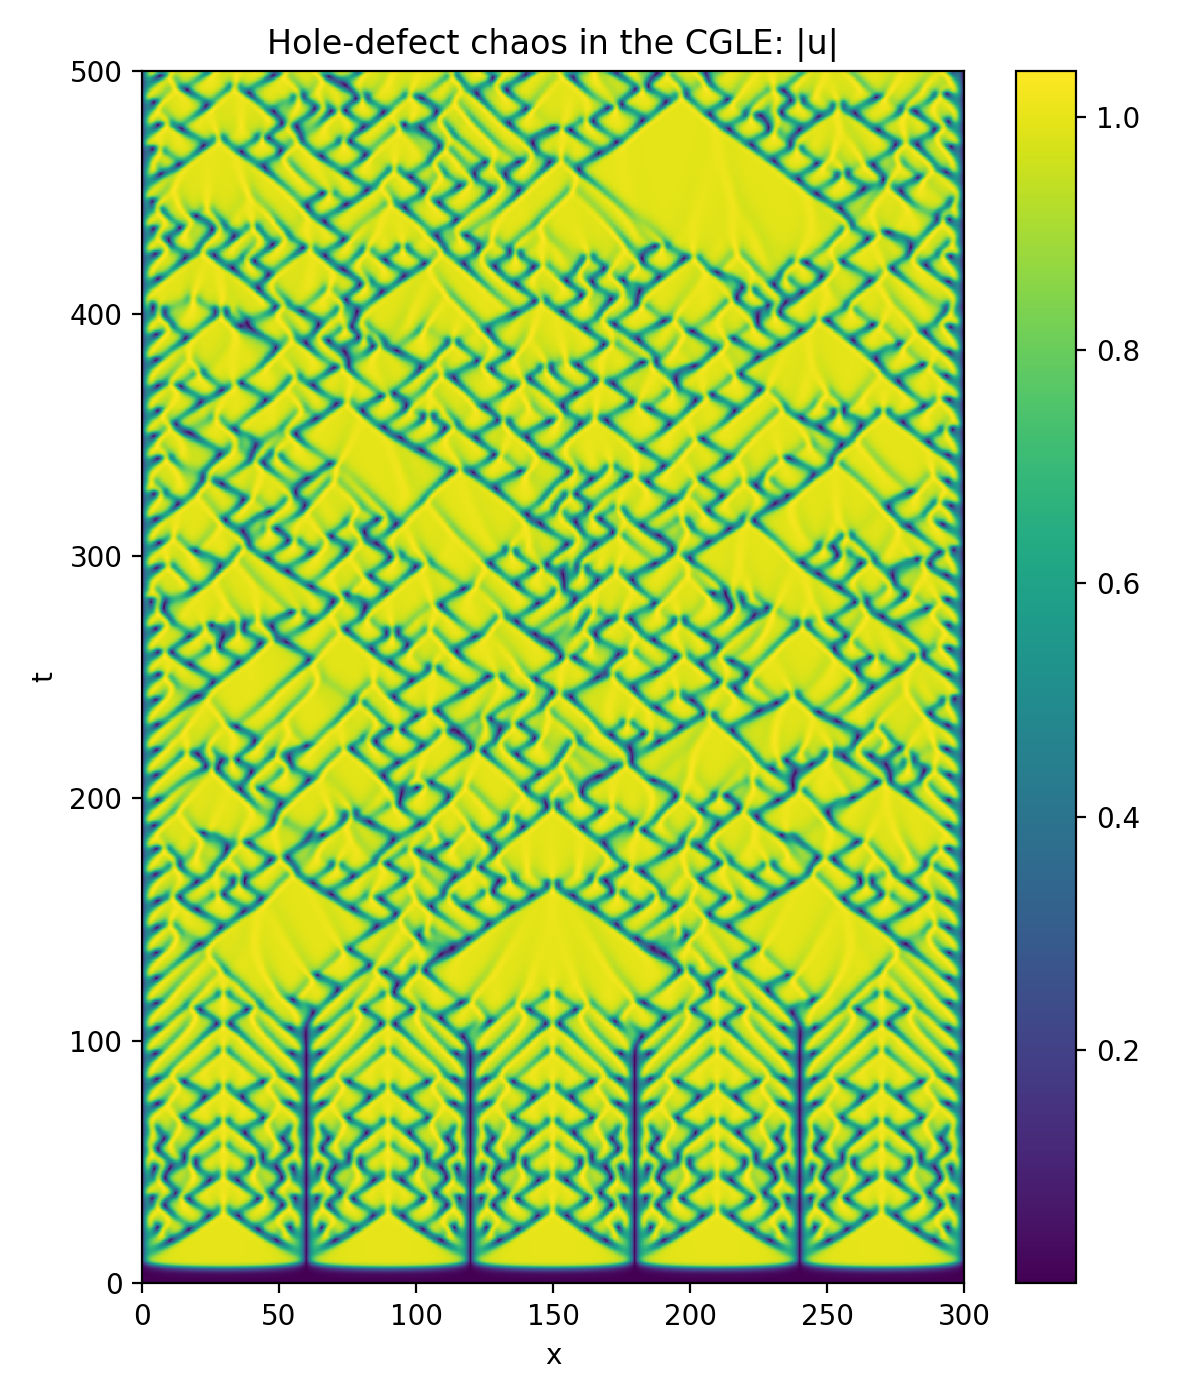

In [13]:
# Plot solution
plt.figure(figsize=(6, 7))
plt.pcolormesh(x, t_array, np.abs(u_array), shading='nearest')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Hole-defect chaos in the CGLE: |u|')
plt.tight_layout()